In [35]:
# Comment the following lines if you're not in colab:
from google.colab import drive
drive.mount('/content/drive')
# If you're in colab, cd to your own working directory here:
%cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-3'
/content/drive/MyDrive/Colab-Notebooks/HY-673-Tutorials/Tutorial-3


In this notebook, we will create and use a GMM manually only by using NumPy. We will make a toy example with 2 Gaussians and a few data points of our choice. <br>

Let's seed up and initialize:

In [36]:
import numpy as np
import matplotlib.pyplot as plt

In [37]:
np.random.seed(42)

priors_old = np.asarray([0.5, 0.5])
means_old = np.asarray([-1, 1])
stddevs_old = np.asarray([1, 1])

x = np.asarray([-5, -3, -1, 2.5, 3.5])  # data points

## 1) <u>E step: Responsibilities:</u>

In the Expectation step we calculate the responsibilities. These are the **posterior** probabilities that a data point belongs to a particular component of the model. In our case, the responsibility $\gamma_{nk}$ represents the probability that the $n$-th data point was generated by the $k$-th Gaussian component.<br>
So, we just need to compute the PDF values for each Gaussian and normalize them w.r.t. their sum: <br> <br>
\begin{equation*}
\gamma_{nk} = \frac{ \pi_{k} \ \mathcal{N}(x_n|\mu_k, \Sigma_k)} {\sum_{j=1}^{K} \pi_{j} \ \mathcal{N}(x_n|\mu_k, \Sigma_k)},
\end{equation*} <br>
where $\pi_k$ is the **mixing coefficient** (probability of choice/prior) for the $k$-th component. Since we'll code it, the expanded version of the above is:<br><br>
\begin{equation*}
\gamma_{nk} = \dfrac{ \pi_{k} \frac{1}{\sqrt{2\pi} \sigma_{k}} \exp \left(  - \frac{(x_n - \mu_k)^2}{2\sigma_{k}^2}  \right)}{\sum_{j=1}^{K
} \pi_{j} \frac{1}{\sqrt{2\pi} \sigma_{j}} \exp \left(- \frac{(x_n - \mu_j)^2}{2\sigma_{j}^2}  \right)}.
\end{equation*}

Let's just compute only the PDFs first. It is tempting to go with a for loop:

In [38]:
def compute_gaussian_pdfs(x, means, stddevs):

    n_gaussians = len(means)
    n_observations = len(x)

    densities = np.zeros((n_observations, n_gaussians))

    for i, (mu, sigma) in enumerate(zip(means, stddevs)):
        coeff = 1/(np.sqrt(2 * np.pi) * sigma)
        diffs = x - mu
        expargs = (diffs**2) / (2 * sigma**2)
        densities[:, i] = coeff*np.exp(-expargs)

    return densities

densities = compute_gaussian_pdfs(x, means_old, stddevs_old)
print(f"densities = \n{densities}\nshape = {densities.shape}\n")

densities = 
[[1.33830226e-04 6.07588285e-09]
 [5.39909665e-02 1.33830226e-04]
 [3.98942280e-01 5.39909665e-02]
 [8.72682695e-04 1.29517596e-01]
 [1.59837411e-05 1.75283005e-02]]
shape = (5, 2)



But, operators are overloaded to work with entire NumPy arrays. Another useful trick, is that we can put in an extra dummy dimension when needed using `None` like this:

In [39]:
print(f"x.shape = {x.shape}\nx[:, None].shape = {x[:, None].shape}")

x.shape = (5,)
x[:, None].shape = (5, 1)


So, a more efficient way to do the same would be:

In [40]:
def compute_gaussian_pdfs(x, means, stddevs):
    coeff = 1/(np.sqrt(2 * np.pi) * stddevs)
    diffs = x[:, None] - means[None, :]
    expargs = -(diffs**2) / (2 * stddevs**2)[None, :]
    densities = coeff[None, :]*np.exp(expargs)
    return densities

densities = compute_gaussian_pdfs(x, means_old, stddevs_old)
print(f"densities = \n{densities}\nshape = {densities.shape}")

densities = 
[[1.33830226e-04 6.07588285e-09]
 [5.39909665e-02 1.33830226e-04]
 [3.98942280e-01 5.39909665e-02]
 [8.72682695e-04 1.29517596e-01]
 [1.59837411e-05 1.75283005e-02]]
shape = (5, 2)


Can also do it in one line...could prove faster, but, it is unreadable:

In [41]:
def compute_gaussian_pdfs(x, means, stddevs):
    return np.exp(-(x[:, None] - means[None, :])**2/(2 * stddevs**2)[None, :])/(np.sqrt(2 * np.pi) * stddevs)[None, :]

densities = compute_gaussian_pdfs(x, means_old, stddevs_old)
print(f"densities = \n{densities}\nshape = {densities.shape}")

densities = 
[[1.33830226e-04 6.07588285e-09]
 [5.39909665e-02 1.33830226e-04]
 [3.98942280e-01 5.39909665e-02]
 [8.72682695e-04 1.29517596e-01]
 [1.59837411e-05 1.75283005e-02]]
shape = (5, 2)


In [42]:
print(f"We have {densities.shape[0]} reponsibilities to calculate since we have {len(x)} data points \
and {densities.shape[1]} responsibilities to calculate for each since we have {len(priors_old)} Gaussians.")

We have 5 reponsibilities to calculate since we have 5 data points and 2 responsibilities to calculate for each since we have 2 Gaussians.


For loop way:

In [43]:
responsibilities = np.zeros_like(densities)

for i, rho in enumerate(densities):
    score = priors_old*rho
    responsibilities[i] = score/sum(score)

print(f"responsibilities = \n {responsibilities}\nshape = {responsibilities.shape}")

responsibilities = 
 [[9.99954602e-01 4.53978687e-05]
 [9.97527377e-01 2.47262316e-03]
 [8.80797078e-01 1.19202922e-01]
 [6.69285092e-03 9.93307149e-01]
 [9.11051194e-04 9.99088949e-01]]
shape = (5, 2)


Better way:

In [44]:
scores = priors_old[None, :]*densities
responsibilities = scores/scores.sum(axis=1)[:, None]
print(f"responsibilities = \n {responsibilities}\nshape = {responsibilities.shape}")

responsibilities = 
 [[9.99954602e-01 4.53978687e-05]
 [9.97527377e-01 2.47262316e-03]
 [8.80797078e-01 1.19202922e-01]
 [6.69285092e-03 9.93307149e-01]
 [9.11051194e-04 9.99088949e-01]]
shape = (5, 2)


## 2) <u>M step: Parameter update</u>

In the Maximization step, the parameters of the mixture components (means, stdds) are updated using the responsibilities computed in the E step. The aim is to maximize the likelihood of the data given the current responsibilities. From theory, to estimate our new priors, means, and stds, we have: <br><br>
\begin{align*}
    \pi_{k}^{\text{new}} &= \frac{N_k}{N}, \\
    \mu_{k}^{\text{new}} &= \frac{1}{N_k} \sum_{n=1}^{N} \gamma_{nk} x_{n}, \\
    \sigma_{k}^{\text{new}} &= \sqrt{ \frac{1}{N_k} \sum_{n=1}^{N} \gamma_{nk} (x_n - \mu_{k}^{\text{new}})^2 },
\end{align*} <br>
with:</br>
\begin{equation*}
N_k=\sum_{n=1}^{N} \gamma_{nk}.
\end{equation*}
One line for each:

In [45]:
Nks = responsibilities.sum(axis=0)
priors_new = Nks/Nks.sum()
means_new = (responsibilities * x[:, None]).sum(axis=0) / Nks
stddevs_new = np.sqrt((responsibilities * (x[:, None] - means_new[None, :])**2 ).sum(axis=0) / Nks)

print(f"Updated priors = {priors_new}\nUpdated means  = {means_new}\nUpdated stds   = {stddevs_new}")

Updated priors = [0.57717659 0.42282341]
Updated means  = [-3.06777216  2.76864114]
Updated stds   = [1.63881968 1.06193525]


## 3) <u>Log-likelihood before and after the M step</u>

Since we have Gaussians, due to their exponential, it is usually preferable to work with the log-likelihood. So, the log-likelihood of a sample $x_1, \dots, x_N$ is simply computed as

\begin{equation*}
\ell(\theta; x) = \sum_{n=1}^{N} \log p_{\theta}(x_{n})
\end{equation*} <br>
If we did all steps correctly, we should see our log-likelihood increase:

In [46]:
def compute_gmm_pdf(x, priors, means, stddevs):
    gaussian_densities = compute_gaussian_pdfs(x, means, stddevs)
    gmm_densities = (priors[None, :] * gaussian_densities).sum(axis=1)
    return gmm_densities

likelihood_old = compute_gmm_pdf(x, priors_old, means_old, stddevs_old).sum()
likelihood_new = compute_gmm_pdf(x, priors_new, means_new, stddevs_new).sum()
print(f"Old log-likelihood = {np.log(likelihood_old)}\n\
New log-likelihood = {np.log(likelihood_new)}")

Old log-likelihood = -1.1160742004747093
New log-likelihood = -0.5909313130012122


Let's also visualize what our GMM looked before the updates:

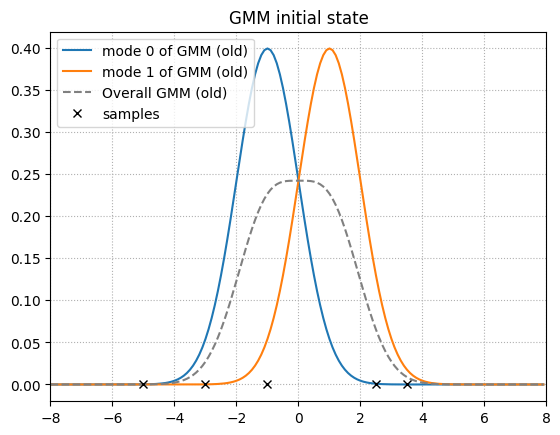

In [47]:
x_range = np.arange(-8, 8, 0.1)
old_likelihoods = compute_gaussian_pdfs(x_range, means_old, stddevs_old)
old_gmm_likelihoods = compute_gmm_pdf(x_range, priors_old, means_old, stddevs_old)

plt.figure()
for i, likelihood in enumerate(old_likelihoods.T):
    plt.plot(x_range, likelihood, label=f'mode {i} of GMM (old)')
plt.plot(x_range, old_gmm_likelihoods, '--', color='gray', label='Overall GMM (old)')
plt.plot(x, np.zeros_like(x), 'x', color='black', label='samples')
plt.xlim([-8, 8])
plt.legend(loc="upper left")
plt.grid(linestyle=':')
plt.title("GMM initial state")
plt.show()
plt.close()

And after the updates:

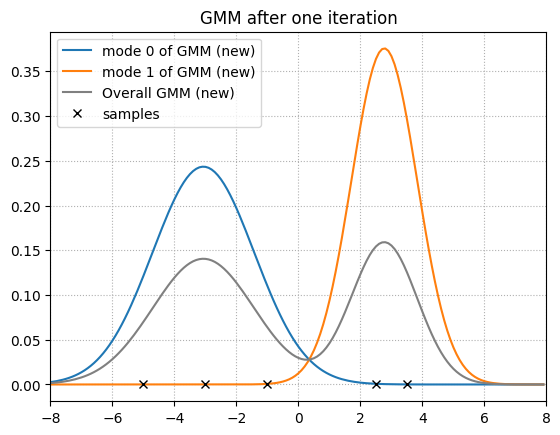

In [48]:
x_range = np.arange(-8, 8, 0.1)
new_likelihoods = compute_gaussian_pdfs(x_range, means_new, stddevs_new)
new_gmm_likelihoods = compute_gmm_pdf(x_range, priors_new, means_new, stddevs_new)
plt.figure()
for i, likelihood in enumerate(new_likelihoods.T):
    plt.plot(x_range, likelihood, label=f'mode {i} of GMM (new)')
plt.plot(x_range, new_gmm_likelihoods, '-', color='gray', label='Overall GMM (new)')
plt.plot(x, np.zeros_like(x), 'x', color='black', label='samples')
plt.xlim([-8, 8])
plt.legend(loc="upper left")
plt.grid(linestyle=':')
plt.title("GMM after one iteration")
plt.show()
plt.close()

## 4) <u>Sampling from our GMM</u>

For loop way:

In [52]:
def sample_gmm(priors, means, stddevs, n):
    # [0, ..., n_gaussians-1]:
    indices_gaussians = np.arange(len(priors))
    # choose the gaussian indices according to the priors:
    random_indices = np.random.choice(a=indices_gaussians, size=n, p=priors)
    # sample n random i.i.d z[i]~N(0,1)
    z_sample = np.random.randn(n)

    gmm_sample = np.zeros_like(z_sample)
    for i, idx in enumerate(random_indices):
        mu = means[idx]
        sigma = stddevs[idx]
        gmm_sample[i] = sigma*z_sample + mu

    return gmm_sample

Better way (vectorized):

In [50]:
def sample_gmm(priors, means, stddevs, n):
    # choose the gaussian indices according to the priors:
    idx_modes = np.random.choice(a=np.arange(len(priors)), size=n, p=priors)
    # sample n random i.i.d z~N(0,1):
    z_sample = np.random.randn(n)
    # scale by std, shift by mean, and return:
    return stddevs[idx_modes]*z_sample + means[idx_modes]

Let us draw some samples using our function and visualize:

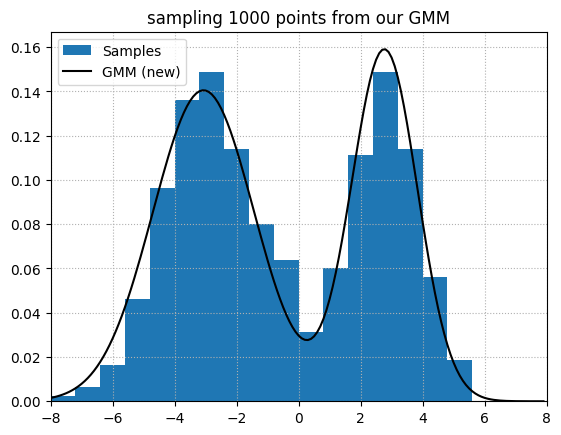

In [51]:
n_samples = 1000

x_sample = sample_gmm(
    priors=priors_new,
    means=means_new,
    stddevs=stddevs_new,
    n=n_samples
)

plt.figure()
plt.hist(x_sample, bins=20, range=(-8, 8), density=True, color='C0', label='Samples')
plt.plot(x_range, new_gmm_likelihoods, '-', color='black', label='GMM (new)')
plt.legend(loc="upper left")
plt.grid(linestyle=':')
plt.title(f"sampling {n_samples} points from our GMM")
plt.xlim([-8, 8])
plt.show()
plt.close()